# Accessing James Webb Space Telescope Data

This tutorial is heavily based on work from Kappi Patterson (https://www.thinkkappi.com).

## What does this tutorial cover?

A concrete walk-through of getting real JWST data and displaying it.
- How to retrieve real JWST data
- Understanding what the data contains
- Displaying the data from the Southern Ring nebula, from the [first images](https://www.nasa.gov/webbfirstimages) released from JWST.

## Of Note

The [official JWST docs](https://jwst-docs.stsci.edu/) are great.

# 1. Set Up

## Astroquery
You'll need python packages that are specifically used by astronomers. We will use the library astroquery, which is affiliated with the astropy project, and makes programatically accessing archives of astronomical data straightforward.

__Note:__ I sometimes get timeout errors using astroquery, and re-running seems to clear them.

1. Install astropy from the instructions [here](https://docs.astropy.org/en/stable/install.html).
2. Install the astroquery library from the instructions [here](https://astroquery.readthedocs.io/en/latest/#installation).

In [21]:
# Check we can load astroquery packages, that we will use later.
from astropy.io import fits
from astroquery.mast import Observations

## JWST Data

JWST data is made available via the Mikulski Archive for Space Telescopes (MAST). This is a huge archive of astronomical data from lots of different missions including Hubble, TESS and Kepler, and is named for [Barabara Mikulski](https://en.wikipedia.org/wiki/Barbara_Mikulski), as US senator who was a big supporter of Hubble and Webb. 

There are several ways to access the data it stores: via the API, bulk AWS download scripts, or you can look at the online portal. For starters, let's search for the Southern Ring planetary nebula observed in JWST's [first images](https://www.nasa.gov/image-feature/goddard/2022/nasa-s-webb-captures-dying-star-s-final-performance-in-fine-detail) in the online portal.

1. Sign up for a MAST portal account (Managed by the Space Telescope Science Institude and called "My Space Telescope" - MyST) [here](https://proper.stsci.edu/proper/authentication/auth).
2. Go to the [online portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) and search for "NGC 3132", which is the object name of the Southern Ring nebula (I just [googled "southern ring nebula object name"](https://www.google.com/search?q=southern+ring+nebula+object+name&rlz=1C5CHFA_enUS999US999&oq=southern+ring+nebula+object+name&aqs=chrome..69i57j33i160.5343j0j7&sourceid=chrome&ie=UTF-8) to find this).
3. Filter by mission in the left sidebar to JWST and you should see 6 NIRCAM observations from June 3 2022, and 4 MIRI observations from June 12 2022. The NIRCAM observations created the image on the left of the [First Images page](https://www.nasa.gov/image-feature/goddard/2022/nasa-s-webb-captures-dying-star-s-final-performance-in-fine-detail), and the MIRI observations created the image on the right.

### Programatic Access

Now we see where the observations live via the UI, let's check we can also access them via our python tools.

1. Test that we can talk to MAST via Astroquery below.

In [101]:
# Limit our query to NGC 3132
obsByName = Observations.query_object("NGC 3132",radius=".02 deg")
print("Number of results from all missions:",len(obsByName))
print(obsByName[:10])

# See if you can see any observations by JWST!
jwst_only = obsByName[(obsByName['obs_collection'] == 'JWST')]
print("\n\n JWST results only \n")
print(jwst_only)

Number of results from all missions: 254
intentType obs_collection provenance_name instrument_name ... mtFlag srcDen  obsid        distance     
---------- -------------- --------------- --------------- ... ------ ------ -------- ------------------
   science          WUPPE              --   ASTRO-2 WUPPE ...     -- 5885.0   389320 1.2211685896009923
   science           TESS            SPOC      Photometer ...  False    nan 62894034                0.0
   science           TESS            SPOC      Photometer ...  False    nan 60827609                0.0
   science    SPITZER_SHA    SSC Pipeline            IRAC ...  False    nan  1748827                0.0
   science    SPITZER_SHA    SSC Pipeline            IRAC ...  False    nan  1748827                0.0
   science    SPITZER_SHA    SSC Pipeline            IRAC ...  False    nan  1748827                0.0
   science    SPITZER_SHA    SSC Pipeline            IRAC ...  False    nan  1748827                0.0
   science    SPITZER_S

# 2. Downloading Data

## Choosing an Observation
Let's concentrate on the NIRCAM observations. Each observation is made up of "data products", which we can list and have a look at in a moment.

Let's start by looking at the available fields in our dataset, using the <code>.keys()</code> method, in order to choose which observation to use. Of interest is that there's an <code>obs_id</code> and an <code>obsid</code>, one of which is a more human readable id than the other, but both function as unique ids.

In [12]:
print(jwst_only.keys(), '\n\n')
print(jwst_only['obsid', 'instrument_name', 'filters', 'obs_id', 't_min'])

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURL', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'distance'] 


 obsid   instrument_name filters                obs_id                      t_min      
-------- --------------- ------- ------------------------------------ -----------------
87602454          NIRCAM   F090W jw02733-o001_t001_nircam_clear-f090w 59733.74120144838
87602522          NIRCAM   F187N jw02733-o001_t001_nircam_clear-f187n 59733.70454250509
87602523          NIRCAM   F212N jw02733-o001_t001_nircam_clear-f212n 59733.66775883611
87602457          NIRCAM   F356W jw02733-o001_t001_nircam_clear-f356w 59733.74120218912
87602459         

The NIRCAM obserations seem to be mainly differentiated by filters used. There are [29 different NIRCAM filters](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-instrumentation/nircam-filters) each giving you images of different parts of the wavelength spectrum. In order to make a beautiful composite image like the one released, you'd want to combine the images from the different filters, but for the simplicity of this tutorial let's just pick one with F444W. 

We'll arbitrarily pick the one that started first (smaller <code>t_min</code>): <code>jw02733-o001_t001_nircam_f405n-f444w</code> / 87602459.

Note that f405n_f444w means that the pupil F405N was used in front of the F444W filter. The image is then a narrow band image around 4.05 microns.

In [73]:
# Pick a particular observation from the list.
obs_87602459 = jwst_only[(jwst_only['obsid'] == '87602459')]
print("\n Observation 87602459 of NGC 3132: \n")
print(obs_87602459)

# Get a list of the "Data Products" available from the observations.
dataProducts = Observations.get_product_list(obs_87602459)
print("\n Data Products: \n")
print(dataProducts)


 Observation 87602459 of NGC 3132: 

intentType obs_collection provenance_name instrument_name project ... mtFlag srcDen  obsid   distance
---------- -------------- --------------- --------------- ------- ... ------ ------ -------- --------
   science           JWST         CALJWST          NIRCAM    JWST ...  False    nan 87602459      0.0

 Data Products: 

 obsID   obs_collection dataproduct_type ... parent_obsid dataRights calib_level
-------- -------------- ---------------- ... ------------ ---------- -----------
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC  

## Choosing a Data Product 

As you can see there are lots of data products. In order to narrow them down, let's look at the <code>calib_level</code> value, which tells us how "raw" the data is. This is important, because data coming directly from the telescope is processed and calibrated to increasining degrees of refinement, so we generally want the highest possible calibration level.

Level 3 is [defined](https://outerspace.stsci.edu/display/MASTDOCS/Science+Data+Products) as "Combined, calibrated science product per target or source", which sounds pretty good. Also, as you can see below, there's a much more manageable number of <code>calib_level</code> 3 data products to contend with:

In [74]:
calibrated = dataProducts[(dataProducts['calib_level'] >= 3)]
print("Found ", len(calibrated), " data products with calibration level >= 3: \n")
print(calibrated)

# See how we can differentiate the products
print("\n",calibrated.keys())
print(calibrated['obsID','productSubGroupDescription','description'])


Found  6  data products with calibration level >= 3: 

 obsID   obs_collection dataproduct_type ... parent_obsid dataRights calib_level
-------- -------------- ---------------- ... ------------ ---------- -----------
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3
87602459           JWST            image ...     87602459     PUBLIC           3

 ['obsID', 'obs_collection', 'dataproduct_type', 'obs_id', 'description', 'type', 'dataURI', 'productType', 'productGroupDescription', 'productSubGroupDescription', 'productDocumentationURL', 'project', 'prvversion', 'proposal_id', 'productFilename', 'size', 'parent_obsid', 'dataRights', 'calib_


Which of these should we download? Reading through [the docs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) on the data product formats, the [I2D](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#resampled-2-d-data-i2d-and-s2d) sounds most like what we want- image data we can display. Let's download it and see.

In [75]:
i2d = calibrated[(calibrated["productSubGroupDescription"] == "I2D")]

# Note that mrp_only should be redundant here- it means "Minimum Recommended Products", which are
# products calibrated finely enough to be reccomended for science use. As we already filtered to
# calib_level >= 3, both our products should be downloaded.
manifest = Observations.download_products(i2d,mrp_only=True)

INFO: Found cached file ./mastDownload/JWST/jw02733-o001_t001_nircam_f405n-f444w/jw02733-o001_t001_nircam_f405n-f444w_i2d.fits with expected size 155024640. [astroquery.query]


In [76]:
manifest

Local Path,Status,Message,URL
str102,str8,object,object
./mastDownload/JWST/jw02733-o001_t001_nircam_f405n-f444w/jw02733-o001_t001_nircam_f405n-f444w_i2d.fits,COMPLETE,None,None


# 3. Loading and Viewing Downloaded Data

Hooray, we successfully downloaded real JWST data! You can see the file extension is .fits, which is a common file format in astronomy. Its docs are [here](https://fits.gsfc.nasa.gov/fits_standard.html), and we imported a fits module from astropy earlier to deal with it.

Lets load in our downloaded data and see if we can display it. We can use built-in functions in the astropy package, (see [astropy docs on reading images](https://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html)) but you could probably manage with just standard matplotlib.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Importing some special packages to display astronomy data.
from matplotlib.colors import LogNorm
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

In [78]:
dp_87602459 = fits.open(manifest['Local Path'][0])

We can poke around this file by using the <code>.info()</code> method to see what is in <code>dp_87602459</code>.

In [102]:
# We can see there are 9 HDUs in the file of various types - one Primary HDU, 7
# ImageHDUs, and 2 trailing BinTableHDUs.
dp_87602459.info()

Filename: ./mastDownload/JWST/jw02733-o001_t001_nircam_f405n-f444w/jw02733-o001_t001_nircam_f405n-f444w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     372   ()      
  1  SCI           1 ImageHDU        75   (2355, 2348)   float32   
  2  ERR           1 ImageHDU        10   (2355, 2348)   float32   
  3  CON           1 ImageHDU         9   (2355, 2348)   int32   
  4  WHT           1 ImageHDU         9   (2355, 2348)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2355, 2348)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2355, 2348)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2355, 2348)   float32   
  8  HDRTAB        1 BinTableHDU    816   8R x 403C   [23A, 5A, 3A, 48A, 7A, 13A, 7A, 5A, 7A, 10A, 4A, L, D, D, D, D, 32A, 48A, 32A, 21A, 3A, 3A, D, D, 10A, 12A, 23A, 23A, 26A, 11A, 5A, 3A, 3A, 2A, 1A, 2A, 1A, L, 14A, 23A, 2A, 26A, 20A, 27A, 10A, K, L, L, L, L, 8A, 8A, 5A, D, D, D, D, D, D, 27A, D,

#### Figuring out the shape of the data

We can use the [docs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#resampled-2-d-data-i2d-and-s2d) to understand shape of our data we saw in the output of <code>.info()</code> above. Of particular interest in the docs is: 

- The file consists of an [HDU list](https://docs.astropy.org/en/stable/io/fits/api/hdulists.html), made up of Header Data Units, which each contain data and a header object that describes the data.
- There is a leading "Primary" HDU containing information about the data product as a whole (but no data), and a trailing HDU containing "ADSF"- the data model metadata. We saw the primary HDU in the cell above.
- For our data product type (<code>I2D</code>), the "SCI" ext name seems to indicate something interesting we could use: _"SCI: 2-D data array containing the pixel values, in units of surface brightness"_. We can see in the <code>.info()</code> output that the <code>SCI</code> data is stored at index 1.

Next, lets look at the <code>SCI</code> object and its header.

In [103]:
# Looking at the header for the second HDU at index 1, we see it describes
# the data it contains, and that it matches the description in the docs - a
# 2D array, with various pieces of metadata. NAXIS1 and NAXIS2 tell us the
# number of pixels in each dimension of the array- so this is a big image!
print("Header of HDU 1 - the 'SCI' ")
dp_87602459[1].header

Header of HDU 1 - the 'SCI' 


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2355                                                  
NAXIS2  =                 2348                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    59733.66775883611 / [d] exposure start time in MJD                 
MJD-AVG =    59733.68472172708 / [d] exposure mid-point in MJD                  
MJD-END =    59733.70168424769 / [d] exposure end time in MJD                   
TDB-BEG =    59733.66709021439 / [d] TDB time of exposure start in MJD          
TDB-MID =    59733.684052388

#### Finally, a picture!
Now that we've looked at the header for the 'SCI' object, and understand what the data's shape is and its meaning, lets look at the data itself.

data shape:  (2348, 2355)


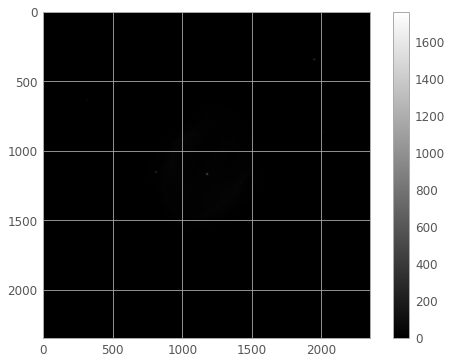

In [95]:
data = dp_87602459[1].data
# As expected, the data is a 2D numpy array
print('data shape: ', np.shape(data))

# Let's plot it as an image and see what we get:
plt.figure()
plt.imshow(data, cmap='gray', norm=LogNorm())
plt.colorbar()

There she is! Now you can get fancy and create a RGB image, by combining different filters, or compare the image to ones taken by earlier missions! For instance you can compare the Spitzer (launched in 2003) and the JWST images of Stephan's Quintet (for data around 8 microns).
  
Now, if you want to do science with these data, you'll need to get the flux from each pixel. The unit is given in the header (it is in MJy/sr), but that's another story :)    

# Resources / Links / More Information
- [JWST Data Guide](https://outerspace.stsci.edu/display/MASTDOCS/Science+Data+Products)
- [JWST Science Product Format Descriptions](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html)